# Dev notebook

### Getting started on the feed forward neural net

In [1]:
import nnfs 
import numpy as np

import matplotlib.pyplot as plt
from nnfs.datasets import spiral_data

nnfs.init()

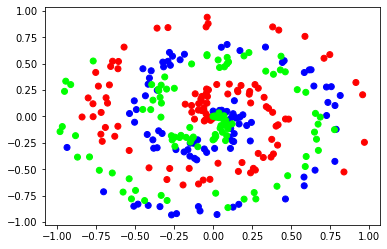

In [2]:
X, y = spiral_data(samples=100, classes=3)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='brg')

####  Defining layers 

Notes:
- I have chosen to use a similar naming convention to that used by pytorch (why reinvent the wheel), this has the benefit of ensuring that when we compar|e implementations the architecture of the networks is the same. 
- since we intend to use ReLU as one of our activation functions we will use the He weight initialization method as described in https://arxiv.org/abs/1502.01852

In [3]:
class LinearLayer():
    """Linear transformation layer of the type o = ixW + b,
    
    where I is the incoming vector, W is the layers weight matrix, b is bias vector and o is the dot product of the 
    i and W plus the bias
    
    Args:
        in_features (int): the size of the input features 
        out_features (int): the size of the output features
        
    Attributes:
        weights (np_array) numpy array of in_features x n_neurons
        biases  (np_array) numpy array of 1 x n_neurons
        inputs  (np_array) numpy array of latest batch of inputs
        d_w     (np_array) The current gradients with respect to the weights 
        d_x     (np_array) The current gradients with respect to the inputs
        d_b     (np_array) The current gradients with respect to the biases
    """

    def __init__(self, in_features, out_features) -> None:
        # initializing weights and biases 
        self.weights = np.random.normal(0.0, np.sqrt(2/in_features), (in_features, out_features))
        self.bias = np.zeros((1, out_features))
        # initializing attributes needed for backwards 
        self.inputs = None

    def forward(self, inputs):
        # Saving inputs for backward step
        self.inputs = inputs
        return np.dot(inputs, self.weights) + self.bias

    def backward(self, d_vals):
        """Backpropagation  of the linear function

        Args:
            d_vals (np_array) array of derivatives from the previous layer/function.
        """
        self.d_w = np.dot(self.inputs.T, d_vals)
        self.d_x = np.dot(d_vals, self.weights.T)
        self.d_b = np.sum(d_vals, axis=0, keepdims=True)


        

#### Testing Linear Layer

In [23]:
linear1 = LinearLayer(2, 3)
linear1.forward(X)

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.35999192e-02, -2.19023135e-03, -4.18973854e-03],
       [-2.84838825e-02, -1.32411998e-03, -1.39295980e-02],
       [-2.95173228e-02,  6.83946442e-03, -2.74063107e-02],
       [-4.27568927e-02,  7.87876267e-03, -3.64948250e-02],
       [-5.91182485e-02, -1.55426851e-02, -8.70032515e-03],
       [-7.64736161e-02,  5.77980885e-03, -5.21437712e-02],
       [-9.99875367e-02, -6.36687828e-03, -4.61822860e-02],
       [-1.13107592e-01, -3.12739564e-03, -5.86790554e-02],
       [-1.12713829e-01,  9.88931488e-03, -7.90191591e-02],
       [-1.27390265e-01,  9.67462454e-03, -8.69350210e-02],
       [-5.31366318e-02,  3.85874957e-02, -9.08415020e-02],
       [-9.54569802e-02,  3.40935700e-02, -1.07546516e-01],
       [-1.34415671e-01,  2.73320917e-02, -1.18778825e-01],
       [-1.04047835e-01,  4.16185558e-02, -1.24265276e-01],
       [-1.02961861e-01,  4.65869829e-02, -1.31502718e-01],
       [ 4.09304015e-02,  6.70890212e-02

#### Activation Functions - ReLu

$$y = \begin{cases}
   x &x> 0 \\
   0 & otherwise
\end{cases} $$

In [24]:
class ReLU:
    """Applies Rectified linear Unit function to vector."""
    def __init__(self) -> None:
        # initializing attributes needed for backwards 
        self.inputs = None
        self.d_relu = None
    
    def forward(self, x):
        # storing inputs needed for backwards 
        self.inputs = x
        return np.maximum(x, 0)
    
    def backward(self, d_vals):
        self.d_relu = d_vals.copy()
        self.d_relu[self.inputs <= 0] = 0

#### Testing ReLU


In [26]:
i = [-2, 3, 4, 0, 0.1, -44]
activator = ReLU()
activator.forward(i)

array([0. , 3. , 4. , 0. , 0.1, 0. ])

#### Activation Functions -Softmax

$$\text{softmax}(x)_i = \frac{exp(x_i)}{\sum_{j}^{ }exp(x_j))}$$

The soft max represents the confidence score for each output class and adds up to 1.

In [7]:
class Softmax:
    """Applies Softmax function to input matrix."""
    def forward(x):
        # exponenets of each value
        exp_vals = np.exp(x - np.max(x, axis=1, keepdims=True))
        exp_sum = np.sum(exp_vals, axis=1, keepdims=True)
        # Normalization to get the proabilities 
        return exp_vals/exp_sum

#### Testing Softmax

In [8]:
softmax = Softmax
softmax.forward([[1,2,44]])

array([[2.11513104e-19, 5.74952226e-19, 1.00000000e+00]])

#### Calculating Loss - Categorical Cross-Entropy

$$ L_i = -\sum_j y_{i,j}\log(\hat{y}_{i,j}) $$

With taking one hot encoding into account we can simplify this down to:

$$ L_i = -y_{i,k}\log(\hat{y}_{i,k}) $$

where K is the index of the correct class

In [9]:
class CategoricalCrossEntropyLoss:
    """Calculates the CCE loss for a given set of predictions.
    This method expect a softmax output and one-hot encoded label mask
    
    y_pred (np_array): matrix of confidence scores of the prediction
    y_true (np_array): matrix of one-hot encoded true lables of the classes
    """
    def forward(y_pred, y_true):
        # Clipping and applying one hot encoded labels as mask 
        # to zero out scores corresponding to incorrect classes
        # We clip to make sure that none of the reaming classes are 0 or 
        # exactly 1 
        corrected = np.sum(np.clip(y_pred, 1e-7, 1-1e-7)*y_true, axis=1)
        # Taking the -ve log of the remaining confidence scores 
        negative_log = -np.log(corrected)
        return np.mean(negative_log)

#### Testing CCE Loss

In [10]:
y_pred = np.array([[0.7, 0.1, 0.2], [0.1,0.5,0.4],[0.02,0.9,0.08]])
y_true = np.array([[1,0,0], [0,1,0], [0,1,0]])

loss_function = CategoricalCrossEntropyLoss
loss_function.forward(y_pred, y_true)

0.38506088005216804

#### One-hot encoding function 

In [11]:
def one_hot_encode_index(y, n):
    one_hot = np.zeros((len(y), n))
    for _y, oh in zip(y, one_hot):
        oh[_y] = 1
    return one_hot

#### Testing one hot masker

In [12]:
n=3
y_test = np.array([0,1,2, 1, 2])

one_hot_encode_index(y_test, n)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

#### Integration Testing 

In [13]:
relu = ReLU
softmax = Softmax
cce_loss = CategoricalCrossEntropyLoss

linear1 = LinearLayer(2, 3)
linear2 = LinearLayer(3, 3)

out1 = relu.forward(linear1.forward(X))
out2 = softmax.forward(linear2.forward(out1))

out2[:10]

array([[0.33333334, 0.33333334, 0.33333334],
       [0.3341291 , 0.33397368, 0.3318973 ],
       [0.33497193, 0.3346509 , 0.33037713],
       [0.33496433, 0.33464476, 0.33039087],
       [0.33571073, 0.33524367, 0.32904556],
       [0.33683243, 0.33614215, 0.3270254 ],
       [0.33764508, 0.336792  , 0.3255629 ],
       [0.33907604, 0.33793384, 0.32299012],
       [0.33979172, 0.33850384, 0.32170445],
       [0.3396643 , 0.33840242, 0.3219332 ]], dtype=float32)

In [14]:
cce_loss.forward(out2, one_hot_encode_index(y, 3))

1.0944197

#### Backpropagation - simplified 

Backpropagation through ReLU, based on the example in NNFS to ensure a solid understanding of the underlying math (partial diff and chain rule) and mechanisms 

In [15]:
# simulating a forward pass 

x = [1.0, -2.0, 3.0]
w = [-3.0, -1.0, 2.0]
b = 1.0

# Multiplying inputs by weights
xw0 = x[0]* w[0]
xw1 = x[1]* w[1]
xw2 = x[2]* w[2]

# Summing weights and bias
z = xw0 + xw1 + xw2 +b

# applying relu
y = max(z, 0)


If we represent the forward pass as a function we can say:

$$\text{ReLU}\left(\sum[\text{inputs}\cdotp\text{weights}]+\text{bias}\right)$$

We now need to find the partial derivatives of all the function for all the parameters. For example if we wanted to know the effect that w0 had on the outcome we woul need to know:

$$ \frac{\partial}{\partial x_0}\left[\text{ReLU}\left(\sum[\text{inputs}\cdotp\text{weights}]+\text{bias}\right)\right] = \frac{d \text{ReLU()}}{d \text{sum()}}\cdot\frac{\partial\text{sum()}}{\partial mul(x_0,w_0)}\cdot\frac{\partial mul(x_0,w_0)}{\partial x_0} $$


In [16]:
# The backward pass

# derivative from previous layers
d_val = 1.0

# the derivative of relu wrt z 
d_relu_dz = d_val * (0,1)[z>0] # == i if z> 0, else 0 

# Recall the derivative of a sum opperator os always 1 
# derivative of the sum wrt x_n*w_n 
d_sum_dxwn = 1
d_relu_dxw0 = d_relu_dz * d_sum_dxwn
d_relu_dxw1 = d_relu_dz * d_sum_dxwn
d_relu_dxw2 = d_relu_dz * d_sum_dxwn

# derivative of the sum wrt b (bias) 
d_sum_db = 1
d_relu_db = d_relu_dz * d_sum_db

# Recall the derivative of a product is whateve input is being multiplied 
d_mul_dx0 = w[0]
d_mul_dx1 = w[1]
d_mul_dx2 = w[2]
d_relu_dx0 = d_mul_dx0 * d_relu_dxw0
d_relu_dx1 = d_mul_dx1 * d_relu_dxw2
d_relu_dx2 = d_mul_dx2 * d_relu_dxw2

d_mul_dw0 = x[0]
d_mul_dw1 = x[1]
d_mul_dw2 = x[2]
d_relu_dw0 = d_mul_dw0 * d_relu_dxw0
d_relu_dw1 = d_mul_dw1 * d_relu_dxw1
d_relu_dw2 = d_mul_dw2 * d_relu_dxw2

# Simplifying the above we can rewrite as:
d_relu_dx0 = d_val * (0,1)[z>0] * w[0]


In [17]:
# Optimized code for the backward pass 
# (yes, variables are being shadowed but it is okay this section is just for learning an not final code)
d_val = 1.0

d_x = [d_val*(0,1)[z>0]*_w for _w in w] # the derivative of the previous layer * d of relu * the corresponding weight for the input
d_w = [d_val*(0,1)[z>0]*_x for _x in x] # the derivative of the previous layer * d of relu * the corresponding input for the weight
d_b = d_val * (0,1)[z>0] # the derivative of the previous layer * d of relu (the derivative of the sum will always be 1)

#### Backpropagation - A layer of neurons 

Considering multiple neurons in a layer rather than just one 

In [18]:
# dummy passed in grads from previous layer 
d_val = np.array([[1.,1.,1.]])

weights = np.array([[0.2, 0.8, -0.5, 1],
                    [0.5, -0.91, 0.26, -0.5],
                    [-0.26, -0.27, 0.17, 0.87]]).T

# gradient for first input  
d_x0 = sum([weights[0][i] * d_val[0][i] for i in range(weights.shape[1])])
d_x1 = sum([weights[1][i] * d_val[0][i] for i in range(weights.shape[1])])
d_x2 = sum([weights[2][i] * d_val[0][i] for i in range(weights.shape[1])])
d_x3 = sum([weights[3][i] * d_val[0][i] for i in range(weights.shape[1])])
d_x = np.array([d_x0, d_x1, d_x2, d_x3])
d_x


array([ 0.44, -0.38, -0.07,  1.37])

In [19]:
# optimizing the above code and accounting for batches of samples we get:

d_val = np.array([[1., 1., 1.],
                    [2., 2., 2.],
                    [3., 3., 3.]])

d_x = np.dot(d_val, weights.T)
d_x

array([[ 0.44, -0.38, -0.07,  1.37],
       [ 0.88, -0.76, -0.14,  2.74],
       [ 1.32, -1.14, -0.21,  4.11]], dtype=float32)

In [20]:
# To calculate the gradients wrt the weights we consider the input values 
inputs = np.array([[1, 2, 3, 2.5],
                    [2., 5., -1., 2],
                    [-1.5, 2.7, 3.3, -0.8]])

d_w = np.dot(inputs.T, d_val)
d_w


array([[ 0.5,  0.5,  0.5],
       [20.1, 20.1, 20.1],
       [10.9, 10.9, 10.9],
       [ 4.1,  4.1,  4.1]], dtype=float32)

In [21]:
# Calculating the derivative of the bias 
d_b = np.sum(d_val, axis=0, keepdims=True)
d_b

array([[6., 6., 6.]])

In [22]:
# output for the linear component 
z = np.array([[1,2,-3,-4], [2,-7,-1,3], [-1, 2,5,-1]])
d_val = np.array([[1,2,3,4], [5,6,7,8], [9,10,11,12]])
# Calcuting the derivative of Relu 
d_relu = np.zeros(z.shape)
d_relu[z>0] = 1
d_relu *= d_val
d_relu 

array([[ 1.,  2.,  0.,  0.],
       [ 5.,  0.,  0.,  8.],
       [ 0., 10., 11.,  0.]], dtype=float32)

At this point I will go back and update the Linear Layer and the Relu with backward code.